In [1]:
# Take care of all requirements.
#!pip install pandas
#!pip install opencv-python
#!pip install matplotlib
#!pip install tensorflow
#!pip install scikit-image

2023-10-13 10:17:07.082109: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Done in 0.6788 seconds


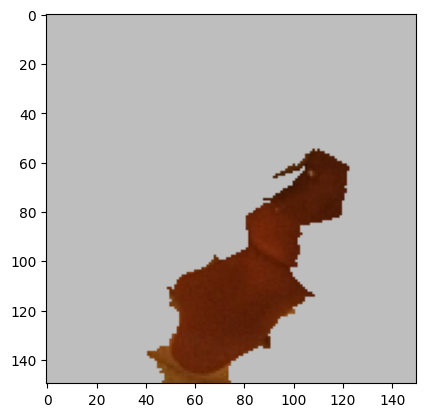

In [2]:
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from CIU import CIU

model = tf.keras.models.load_model("model_full_categorical.h5")
image_path = "Set1_674.png"
out_names = ["NonBleeding", "Bleeding"]

ciu_object = CIU(model, out_names, image_path, (150, 150), True)

tic = time.perf_counter()
image_output = ciu_object.CIU_Explanation()
toc = time.perf_counter()
print(f"Done in {toc - tic:0.4f} seconds")

plt.imshow(image_output)
plt.show()